# Project CVAE on MNIST datas

In [1]:
# Imports
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Loading Fashion-MNIST datasets
# Note: to improve speed we could save images as flatten images (using tranform for example)
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [60]:
# Global values
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
MAX_EPOCHS = 30
LEARNING_RATE = 1e-3
CLASSES_TO_IDX = train_dataset.class_to_idx
FEATURE_SIZE = train_dataset.data[0].shape[0]
CLASS_SIZE = 10
LATENT_SIZE = 10

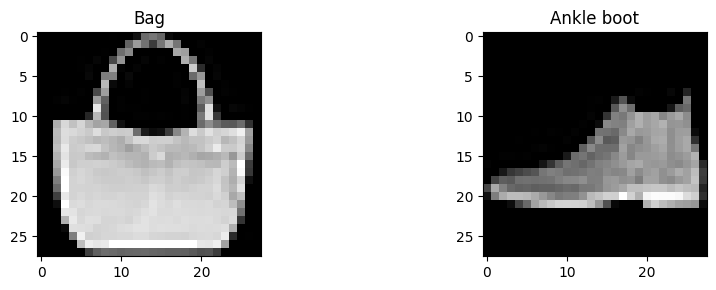

In [4]:
# Print the first image of each dataset
# Note: Do not run it after splitting datas into validation and test sets
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axs[0].imshow(train_dataset.data[100], cmap='gray')
axs[0].set_title(f"{list(CLASSES_TO_IDX.keys())[train_dataset.targets[100]]}")

axs[1].imshow(test_dataset.data[0], cmap='gray')
axs[1].set_title(f"{list(CLASSES_TO_IDX.keys())[test_dataset.targets[0]]}")

plt.tight_layout()
plt.show()

In [5]:
# Split test between validation and test
val_size = int(test_dataset.data.shape[0] / 2)
test_size = test_dataset.data.shape[0] - val_size
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

# Some prints
print(f"Train dataset size: {len(train_dataset.data)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Makes dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset size: 60000
Validation dataset size: 5000
Test dataset size: 5000


In [61]:
# See https://github.com/unnir/cVAE/blob/master/cvae.py
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size * feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size * feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

        # Center for each class in latent space
        self.class_centers = nn.Parameter(torch.randn(class_size, latent_size))

    def encode(self, x, c): # Q(z|x, c)
        inputs = torch.cat([x, c], 1)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        inputs = torch.cat([z, c], 1)
        h3 = self.elu(self.fc3(inputs))
        recon = self.sigmoid(self.fc4(h3))
        return recon.view(inputs.size(0), 1, self.feature_size, self.feature_size)

    def forward(self, x, c):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x, c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

In [62]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [8]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(DEVICE)

In [9]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD
cvae = CVAE(FEATURE_SIZE, LATENT_SIZE, CLASS_SIZE)
cvae.to(DEVICE)
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)
# StepLR Scheduler (réduit le learning rate de gamma, donc ici 0.1, toutes les 10 epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

for epoch in range(1, MAX_EPOCHS + 1):
    # On affiche le learning rate actuel
    current_lr = get_lr(optimizer)
    print(f"Epoch {epoch}/{MAX_EPOCHS} - Learning Rate: {current_lr:.6f}")

    # Training part
    cvae.train()
    running_train_loss = 0.0
    t_train = tqdm(train_loader, desc=f"Epoch {epoch}/{MAX_EPOCHS} Training")
    for data, labels in t_train:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        labels = one_hot(labels, CLASS_SIZE)
        recon_batch, mu, logvar = cvae(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader.dataset)

    # Validation part
    cvae.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        running_val_loss = 0.0
        t_val = tqdm(val_loader, desc=f"Epoch {epoch}/{MAX_EPOCHS} Validation")
        for data, labels in t_val:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            labels = one_hot(labels, CLASS_SIZE)
            recon_batch, mu, logvar = cvae(data, labels)            
            loss = loss_function(recon_batch, data, mu, logvar)

            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader.dataset)
    
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')
    # Step the scheduler
    scheduler.step()

# Saving part (if needed)
torch.save(cvae.state_dict(), 'cvae_weights.pth')

Epoch 1/30 - Learning Rate: 0.001000


Epoch 1/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 102.13it/s]


Epoch 1, Training loss: 267.2430, Validation loss: 255.6643
Epoch 2/30 - Learning Rate: 0.001000


Epoch 2/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 102.01it/s]


Epoch 2, Training loss: 250.5950, Validation loss: 250.2437
Epoch 3/30 - Learning Rate: 0.001000


Epoch 3/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 99.59it/s] 


Epoch 3, Training loss: 246.8077, Validation loss: 246.9879
Epoch 4/30 - Learning Rate: 0.001000


Epoch 4/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 99.14it/s]


Epoch 4, Training loss: 244.7388, Validation loss: 246.3051
Epoch 5/30 - Learning Rate: 0.001000


Epoch 5/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 103.69it/s]


Epoch 5, Training loss: 243.4441, Validation loss: 243.7417
Epoch 6/30 - Learning Rate: 0.001000


Epoch 6/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 82.04it/s]


Epoch 6, Training loss: 242.4869, Validation loss: 243.7357
Epoch 7/30 - Learning Rate: 0.001000


Epoch 7/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 83.03it/s]


Epoch 7, Training loss: 241.7216, Validation loss: 243.3797
Epoch 8/30 - Learning Rate: 0.001000


Epoch 8/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 83.83it/s]


Epoch 8, Training loss: 241.1693, Validation loss: 242.2118
Epoch 9/30 - Learning Rate: 0.001000


Epoch 9/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 85.59it/s]


Epoch 9, Training loss: 240.6618, Validation loss: 242.7020
Epoch 10/30 - Learning Rate: 0.001000


Epoch 10/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 84.14it/s]


Epoch 10, Training loss: 240.2897, Validation loss: 242.2690
Epoch 11/30 - Learning Rate: 0.000100


Epoch 11/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 81.43it/s]


Epoch 11, Training loss: 238.5458, Validation loss: 239.9271
Epoch 12/30 - Learning Rate: 0.000100


Epoch 12/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 81.32it/s]


Epoch 12, Training loss: 238.4272, Validation loss: 239.8871
Epoch 13/30 - Learning Rate: 0.000100


Epoch 13/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 82.83it/s]


Epoch 13, Training loss: 238.3624, Validation loss: 239.7196
Epoch 14/30 - Learning Rate: 0.000100


Epoch 14/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 86.74it/s]


Epoch 14, Training loss: 238.3264, Validation loss: 239.7644
Epoch 15/30 - Learning Rate: 0.000100


Epoch 15/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 83.74it/s]


Epoch 15, Training loss: 238.2567, Validation loss: 239.7672
Epoch 16/30 - Learning Rate: 0.000100


Epoch 16/30 Validation: 100%|██████████| 79/79 [00:01<00:00, 69.37it/s]


Epoch 16, Training loss: 238.1958, Validation loss: 239.6711
Epoch 17/30 - Learning Rate: 0.000100


Epoch 17/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 83.68it/s]


Epoch 17, Training loss: 238.1913, Validation loss: 239.6255
Epoch 18/30 - Learning Rate: 0.000100


Epoch 18/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 85.56it/s]


Epoch 18, Training loss: 238.1165, Validation loss: 239.6332
Epoch 19/30 - Learning Rate: 0.000100


Epoch 19/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 83.82it/s]


Epoch 19, Training loss: 238.0785, Validation loss: 239.5328
Epoch 20/30 - Learning Rate: 0.000100


Epoch 20/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 84.65it/s]


Epoch 20, Training loss: 238.0434, Validation loss: 239.4543
Epoch 21/30 - Learning Rate: 0.000010


Epoch 21/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 85.50it/s]


Epoch 21, Training loss: 237.8686, Validation loss: 239.4009
Epoch 22/30 - Learning Rate: 0.000010


Epoch 22/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 85.25it/s]


Epoch 22, Training loss: 237.8266, Validation loss: 239.2810
Epoch 23/30 - Learning Rate: 0.000010


Epoch 23/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 95.24it/s]


Epoch 23, Training loss: 237.7990, Validation loss: 239.3225
Epoch 24/30 - Learning Rate: 0.000010


Epoch 24/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 96.55it/s] 


Epoch 24, Training loss: 237.8250, Validation loss: 239.2841
Epoch 25/30 - Learning Rate: 0.000010


Epoch 25/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 100.54it/s]


Epoch 25, Training loss: 237.8189, Validation loss: 239.3421
Epoch 26/30 - Learning Rate: 0.000010


Epoch 26/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 101.91it/s]


Epoch 26, Training loss: 237.8055, Validation loss: 239.3113
Epoch 27/30 - Learning Rate: 0.000010


Epoch 27/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 107.46it/s]


Epoch 27, Training loss: 237.7786, Validation loss: 239.2676
Epoch 28/30 - Learning Rate: 0.000010


Epoch 28/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 107.60it/s]


Epoch 28, Training loss: 237.7858, Validation loss: 239.2033
Epoch 29/30 - Learning Rate: 0.000010


Epoch 29/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 89.75it/s]


Epoch 29, Training loss: 237.7913, Validation loss: 239.3336
Epoch 30/30 - Learning Rate: 0.000010


Epoch 30/30 Validation: 100%|██████████| 79/79 [00:00<00:00, 100.71it/s]

Epoch 30, Training loss: 237.7867, Validation loss: 239.2568


Testing...: 100%|██████████| 79/79 [00:01<00:00, 74.46it/s]


Test loss: 240.28193491210936 -- MSE: 12.228510520935059


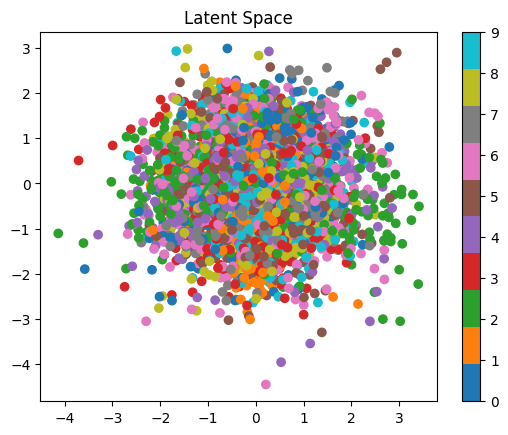

In [64]:
# Loading model
cvae = CVAE(FEATURE_SIZE, LATENT_SIZE, CLASS_SIZE)
cvae.to(DEVICE)
cvae.load_state_dict(torch.load('cvae_weights.pth', weights_only=True))
cvae.eval()

# Plot
fig, ax = plt.subplots()
scatter = ax.scatter([], [], c=[], cmap='tab10', vmin=0, vmax=9)

with torch.no_grad():
    running_test_loss = 0.0
    total_mse = 0.0
    number_images = 0
    residuals_sum = 0
    t_test = tqdm(test_loader, desc="Testing...")
    for data, labels in t_test:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        labels = one_hot(labels, CLASS_SIZE)
        recon_batch, mu, logvar = cvae(data, labels) 
        loss = loss_function(recon_batch, data, mu, logvar)
        mse_value = F.mse_loss(recon_batch, data, reduction='sum') 
        total_mse += mse_value.item()
        residuals_sum += torch.abs(data - recon_batch).sum(dim=0) # (1, 28, 28) where 1 is the channel number
        number_images += labels.size(0)

        running_test_loss += loss.item()

        # Plot part
        mu, labels = mu.cpu(), labels.cpu()
        scatter = ax.scatter(mu[:,0], mu[:,1], c=[labels.argmax(dim=1)], cmap='tab10', vmin=0, vmax=9)        
        
test_loss = running_test_loss / len(test_loader.dataset)
MSE = total_mse / number_images
print(f"Test loss: {test_loss} -- MSE: {MSE}")

plt.colorbar(scatter)
plt.title("Latent Space")
plt.show()

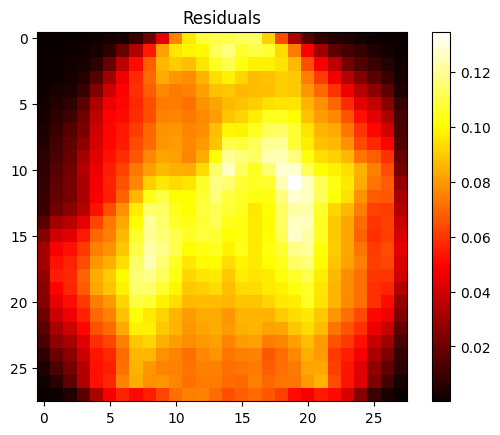

In [ ]:
# Plot residuals
residuals_mean = residuals_sum / number_images
residuals_mean_np = residuals_mean.cpu().numpy().squeeze()  # (28, 28) The squeeze is used to delete channel dim

plt.imshow(residuals_mean_np, cmap='hot')
plt.title('Residuals')
plt.colorbar()
plt.show()

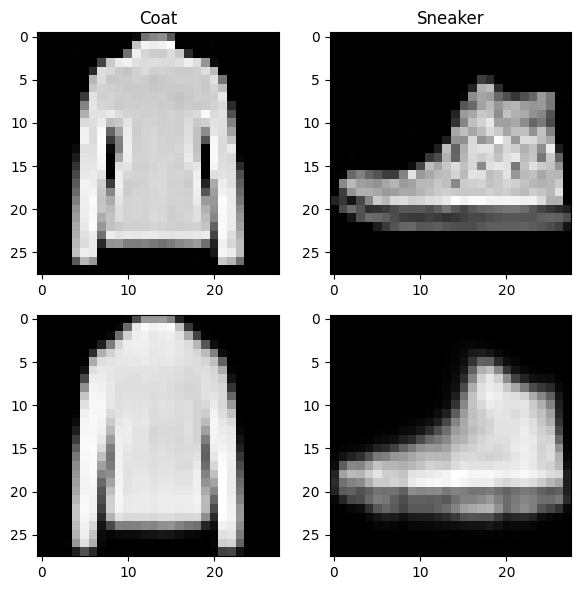

In [79]:
# Makes some plots
def plot_test(cvae):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6))

    loader_iter = iter(test_loader)

    data1, labels1 = next(loader_iter)
    data1, labels1 = data1.to(DEVICE), labels1.to(DEVICE)
    labels1 = one_hot(labels1, CLASS_SIZE)
    recon1, _, _ = cvae(data1, labels1)

    data2, labels2 = next(loader_iter)
    data2, labels2 = data2.to(DEVICE), labels2.to(DEVICE)
    labels2 = one_hot(labels2, CLASS_SIZE)
    recon2, _, _ = cvae(data2, labels2)

    # Moving back to cpu
    data1, data2 = data1.cpu(), data2.cpu()
    labels1, labels2 = labels1.cpu(), labels2.cpu()
    recon1, recon2 = recon1.detach().cpu(), recon2.detach().cpu()

    # Plots
    i = random.randint(0, BATCH_SIZE - 1)
    axs[0,0].imshow(data1[i].squeeze(), cmap='gray')
    axs[0,0].set_title(f"{list(CLASSES_TO_IDX.keys())[labels1[i].argmax()]}")

    axs[0,1].imshow(data2[i].squeeze(), cmap='gray')
    axs[0,1].set_title(f"{list(CLASSES_TO_IDX.keys())[labels2[i].argmax()]}")

    axs[1,0].imshow(recon1[i].squeeze(), cmap='gray')
    axs[1,1].imshow(recon2[i].squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()
    pass
plot_test(cvae)

### Une autre Loss pour ne pas avoir des classes superposées

In [25]:
#Cette perte fonctionne en choisissant trois exemples :
#Ancre : un point latent de la classe cible.
#Positif : un autre point latent de la même classe.
#Négatif : un point latent d'une classe différente.
#La triplet loss pousse l’ancre et le positif à se rapprocher, et l’ancre et le négatif à s'éloigner. Cela peut être plus efficace pour séparer les classes.

def triplet_loss(mu, labels, margin=1.0):
    batch_size = mu.size(0)
    loss = 0
    for i in range(batch_size):
        anchor = mu[i]
        pos_indices = (labels == labels[i]).nonzero().view(-1)
        neg_indices = (labels != labels[i]).nonzero().view(-1)
        
        if len(pos_indices) > 1 and len(neg_indices) > 0:
            pos_index = pos_indices[torch.randint(1, len(pos_indices), (1,))].item()
            neg_index = neg_indices[torch.randint(0, len(neg_indices), (1,))].item()
            positive = mu[pos_index]
            negative = mu[neg_index]
            
            # Triplet loss calculation
            pos_dist = torch.sum((anchor - positive) ** 2)
            neg_dist = torch.sum((anchor - negative) ** 2)
            loss += torch.relu(pos_dist - neg_dist + margin)
    loss /= batch_size
    return loss

In [92]:
def new_loss(recon_x, x, mu, logvar, labels, class_centers, beta=1, lambda_center=0.1, lambda_triplet=5):
    # Reconstruction loss
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Center loss
    batch_size = mu.size(0)
    center_loss = 0
    for i in range(batch_size):
        target_center = class_centers[labels[i].argmax()]  # get the center for the correct class
        center_loss += torch.sum((mu[i] - target_center) ** 2)  # distance to the target center
    center_loss /= batch_size
    
    # Triplet loss for better separation
    triplet_loss_value = triplet_loss(mu, labels.argmax(dim=1))
    
    # Total loss with center loss and triplet loss
    return BCE + beta * KLD + lambda_center * center_loss + lambda_triplet * triplet_loss_value

In [101]:
cvae_new_loss = CVAE(FEATURE_SIZE, LATENT_SIZE, CLASS_SIZE)
cvae_new_loss.to(DEVICE)
optimizer = optim.Adam(cvae_new_loss.parameters(), lr=LEARNING_RATE)
# StepLR Scheduler (réduit le learning rate de gamma, donc ici 0.1, toutes les 10 epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
MAX_EPOCHS = 10
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

for epoch in range(1, MAX_EPOCHS + 1):
    # On affiche le learning rate actuel
    current_lr = get_lr(optimizer)
    print(f"Epoch {epoch}/{MAX_EPOCHS} - Learning Rate: {current_lr:.6f}")

    # Training part
    cvae_new_loss.train()
    running_train_loss = 0.0
    t_train = tqdm(train_loader, desc=f"Epoch {epoch}/{MAX_EPOCHS} Training")
    for data, labels in t_train:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        labels = one_hot(labels, CLASS_SIZE)
        recon_batch, mu, logvar = cvae_new_loss(data, labels)
        optimizer.zero_grad()
        beta = min(0.01 , 0.2 )  # augmenter progressivement jusqu'à target_beta
        lambda_triplet = min(2+ epoch * 0.5, 8)  # target_lambda_triplet peut être fixé à 15 ou 20
        loss = loss_function(recon_batch, data, mu, logvar, labels, cvae_new_loss.class_centers, beta=beta, lambda_triplet=lambda_triplet)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    train_loss = running_train_loss / len(train_loader.dataset)

    # Validation part
    cvae_new_loss.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        running_val_loss = 0.0
        t_val = tqdm(val_loader, desc=f"Epoch {epoch}/{MAX_EPOCHS} Validation")
        for data, labels in t_val:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            labels = one_hot(labels, CLASS_SIZE)
            recon_batch, mu, logvar = cvae_new_loss(data, labels)            
            loss = loss_function(recon_batch, data, mu, logvar, labels, cvae_new_loss.class_centers)

            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader.dataset)
    
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')
    # Step the scheduler
    scheduler.step()

# Saving part (if needed)
torch.save(cvae_new_loss.state_dict(), 'cvae_weights.pth')

Epoch 1/10 - Learning Rate: 0.001000


Epoch 1/10 Validation: 100%|██████████| 79/79 [00:09<00:00,  8.47it/s]


Epoch 1, Training loss: 244.2756, Validation loss: 308.5405
Epoch 2/10 - Learning Rate: 0.001000


Epoch 2/10 Validation: 100%|██████████| 79/79 [00:09<00:00,  8.13it/s]


Epoch 2, Training loss: 228.1052, Validation loss: 296.8319
Epoch 3/10 - Learning Rate: 0.001000


Epoch 3/10 Validation: 100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


Epoch 3, Training loss: 225.4481, Validation loss: 290.9768
Epoch 4/10 - Learning Rate: 0.001000


Epoch 4/10 Validation: 100%|██████████| 79/79 [00:12<00:00,  6.47it/s]


Epoch 4, Training loss: 223.9520, Validation loss: 286.5712
Epoch 5/10 - Learning Rate: 0.001000


Epoch 5/10 Validation: 100%|██████████| 79/79 [00:09<00:00,  8.11it/s]


Epoch 5, Training loss: 223.0224, Validation loss: 284.7753
Epoch 6/10 - Learning Rate: 0.001000


Epoch 6/10 Validation: 100%|██████████| 79/79 [00:09<00:00,  8.66it/s]


Epoch 6, Training loss: 222.3226, Validation loss: 281.9448
Epoch 7/10 - Learning Rate: 0.001000


Epoch 7/10 Validation: 100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


Epoch 7, Training loss: 221.8020, Validation loss: 279.7397
Epoch 8/10 - Learning Rate: 0.001000


Epoch 8/10 Validation: 100%|██████████| 79/79 [00:10<00:00,  7.86it/s]


Epoch 8, Training loss: 221.3344, Validation loss: 278.6361
Epoch 9/10 - Learning Rate: 0.001000


Epoch 9/10 Validation: 100%|██████████| 79/79 [00:09<00:00,  8.58it/s]


Epoch 9, Training loss: 220.9954, Validation loss: 279.2632
Epoch 10/10 - Learning Rate: 0.001000


Epoch 10/10 Validation: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s]

Epoch 10, Training loss: 220.6643, Validation loss: 277.7019


Testing...: 100%|██████████| 79/79 [00:09<00:00,  8.39it/s]


Test loss: 278.27716928710936 -- MSE: 10.693847201538086


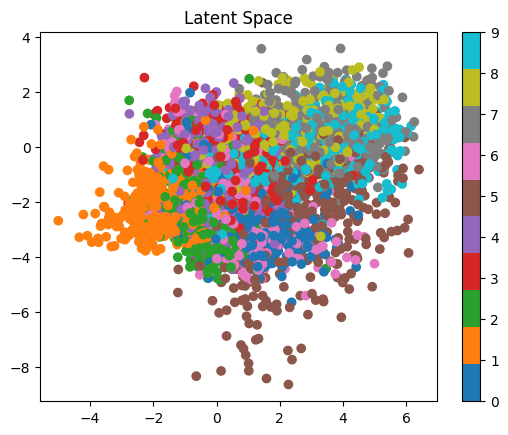

In [102]:
# Plot
fig, ax = plt.subplots()
scatter = ax.scatter([], [], c=[], cmap='tab10', vmin=0, vmax=9)

with torch.no_grad():
    running_test_loss = 0.0
    total_mse = 0.0
    number_images = 0
    residuals_sum = 0
    t_test = tqdm(test_loader, desc="Testing...")
    for data, labels in t_test:
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        labels = one_hot(labels, CLASS_SIZE)
        recon_batch, mu, logvar = cvae_new_loss(data, labels) 
        loss = loss_function(recon_batch, data, mu, logvar, labels, cvae_new_loss.class_centers)
        mse_value = F.mse_loss(recon_batch, data, reduction='sum') 
        total_mse += mse_value.item()
        residuals_sum += torch.abs(data - recon_batch).sum(dim=0) # (1, 28, 28) where 1 is the channel number
        number_images += labels.size(0)

        running_test_loss += loss.item()

        # Plot part
        mu, labels = mu.cpu(), labels.cpu()
        scatter = ax.scatter(mu[:,0], mu[:,1], c=[labels.argmax(dim=1)], cmap='tab10', vmin=0, vmax=9)        
        
test_loss = running_test_loss / len(test_loader.dataset)
MSE = total_mse / number_images
print(f"Test loss: {test_loss} -- MSE: {MSE}")

plt.colorbar(scatter)
plt.title("Latent Space")
plt.show()

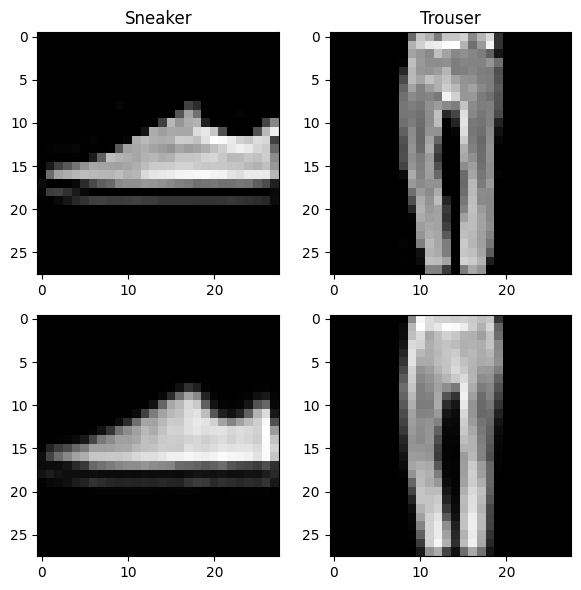

In [95]:
plot_test(cvae_new_loss)